In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns
import math

In [2]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# Dataset Description

## Subscriptions

In [3]:
def parse_date(dates):
    return [
        datetime.strptime(f"{d}", '%b-%y') if isinstance(d, str) 
        else float("nan") 
        for d in dates
    ]

subs = pd.read_csv(
    "user_subscriptions.csv", 
    index_col="CustomerID", 
    parse_dates=["Join Date", "End Date"],
    date_parser=parse_date
)

subs["Affluence"] = subs["Affluence"].astype("category").cat.set_categories(
    ["A", "B", "C1", "C2", "DE"], ordered=True
)

In [4]:
subs.head()

Club  Join Date Affluence  Gender Subscription Type  \
CustomerID                                                             
1             Enfield 2011-12-01        C1    Male          Standard   
2           Greenwich 2018-06-01         A  Female          Standard   
3           Islington 2018-03-01         B  Female          Standard   
4            Hounslow 2015-10-01        C1  Female          Standard   
5              Barnet 2015-05-01        C2    Male          Standard   

             End Date  BirthYear  
CustomerID                        
1          2011-12-01       1992  
2                 NaT       1972  
3          2018-10-01       1985  
4          2015-12-01       1972  
5          2015-12-01       1982

In [5]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850033 entries, 1 to 850033
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Club               850033 non-null  object        
 1   Join Date          850033 non-null  datetime64[ns]
 2   Affluence          850033 non-null  category      
 3   Gender             850033 non-null  object        
 4   Subscription Type  850033 non-null  object        
 5   End Date           797656 non-null  datetime64[ns]
 6   BirthYear          850033 non-null  int64         
dtypes: category(1), datetime64[ns](2), int64(1), object(3)
memory usage: 46.2+ MB


In [6]:
def compute_age(row):
    return row["Join Date"].year - row["BirthYear"]

subs["age"] = subs.apply(compute_age, axis=1)

In [7]:
subs["age_band"] = pd.cut(
    subs["age"], 
    bins=(18, 25, 30, 35, 40, 45, 50, 55, 99), 
    labels=["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55+"],
    include_lowest=True
)
subs["age_band"] = subs["age_band"].astype("category").cat.set_categories(
    ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55+"], ordered=True
)

In [8]:
def compute_tenure(row):
    if pd.isnull(row["End Date"]):
        return np.nan
    
    end = row["End Date"]
    start = row["Join Date"]
    return diff_month(end, start)

subs["tenure"] = subs.apply(compute_tenure, axis=1)
subs["tenure"] = subs["tenure"].fillna(subs["tenure"].mean())

In [9]:
subs.head()

Club  Join Date Affluence  Gender Subscription Type  \
CustomerID                                                             
1             Enfield 2011-12-01        C1    Male          Standard   
2           Greenwich 2018-06-01         A  Female          Standard   
3           Islington 2018-03-01         B  Female          Standard   
4            Hounslow 2015-10-01        C1  Female          Standard   
5              Barnet 2015-05-01        C2    Male          Standard   

             End Date  BirthYear  age age_band    tenure  
CustomerID                                                
1          2011-12-01       1992   19    18-24  0.000000  
2                 NaT       1972   46    45-49  4.007325  
3          2018-10-01       1985   33    30-34  7.000000  
4          2015-12-01       1972   43    40-44  2.000000  
5          2015-12-01       1982   33    30-34  7.000000

## Visits

In [11]:
visits1 = pd.read_csv(
    "visitationdataPART1.csv", 
    parse_dates={'visit_datetime': ['visitdate', 'TimeofVisit']},
)

In [12]:
visits2 = pd.read_csv(
    "visitationdataPART2.csv", 
    parse_dates={'visit_datetime': ['visitdate', 'TimeofVisit']},
)

In [13]:
visits = pd.concat([visits1, visits2])

In [14]:
visits.head()

visit_datetime  CustomerID  peakvisits
0 2009-05-01 05:45:00      126444       False
1 2009-05-01 05:45:00      456610       False
2 2009-05-01 06:00:00      293763       False
3 2009-05-01 06:15:00      151253       False
4 2009-05-01 06:15:00      476569       False

In [15]:
full = visits.join(subs, on="CustomerID", how="left")

We start by loading the dataset and apply some simple transformations to clean the data. We merge the `subscription` dataset with the `visitation` dataset.

In [16]:
full.head()

visit_datetime  CustomerID  peakvisits      Club  Join Date Affluence  \
0 2009-05-01 05:45:00      126444       False  Hounslow 2009-05-01         B   
1 2009-05-01 05:45:00      456610       False  Hounslow 2009-05-01         B   
2 2009-05-01 06:00:00      293763       False  Hounslow 2009-05-01        C1   
3 2009-05-01 06:15:00      151253       False  Hounslow 2009-05-01        C1   
4 2009-05-01 06:15:00      476569       False  Hounslow 2009-05-01         A   

   Gender Subscription Type   End Date  BirthYear  age age_band  tenure  
0    Male          Standard 2009-08-01       1989   20    18-24     3.0  
1    Male          Flexible 2009-05-01       1989   20    18-24     0.0  
2    Male          Standard 2009-07-01       1973   36    35-39     2.0  
3    Male          Standard 2009-08-01       1991   18    18-24     3.0  
4  Female          Standard 2009-10-01       1982   27    25-29     5.0

## Club Affluence

We start our analysis by looking at the difference of daily affluence in the different clubs. We compute the average daily affluence for each club and observe quite a big difference between the busiest club Havering with an average of 1355 daily visits and Redbridge, the club with the lowest average daily visits, with only 802 visits per day. Looking at all the clubs we see that the daily affluence is uniformly distributed between 802 and 1355.

**Actionable insights:**

The interesting aspect here is to see the big difference between the clubs. 
- It would be interesting to see if we could even out the number of visits across the gyms. That would most likely lead to a higher customer satisfaction. An idea to do so would be to reduce the price in the gym less frequented.

In [21]:
club_affluence = full.groupby(
    ["Club", pd.Grouper(key="visit_datetime", freq="1D")]
).agg({
    "CustomerID": "count"
}).reset_index().rename(
    columns={"CustomerID": "visitors"}
).groupby("Club").agg({
    "visitors": ["mean", "std"]
}).xs(
    "visitors", axis=1, drop_level=True
).sort_values(by=["mean"], ascending=False)

#### High

In [22]:
display(sorted_data.head(5))

mean         std
Club                                           
Havering                1355.553610  171.953344
Kensington and Chelsea  1287.723350  244.693927
Barking                 1273.084666  241.798204
Bromley                 1223.883392  227.874369
Wandsworth              1219.845244  170.413505

#### Low

In [23]:
display(sorted_data.tail(5))

mean         std
Club                              
Hillingdon  947.198582  210.860949
Haringey    917.660377  117.849536
Sutton      898.077096  110.631773
Enfield     888.232258  132.199011
Redbridge   802.927152  200.297058

## Monthly visits by Club

We then decide to look at the number of monthly visits for each club. All the clubs have generally the same trend of number of visits by month. We note however a difference between new clubs and established clubs. It seems that once open, a club sees the number of monthly visits increase for the first three months until it plateaus. We assume that this number is likely the number at which the club reaches its full capacity and people are naturally leaving the gym or not visiting anymore because of how busy it is.
More generally we observe what the client was saying about the slow down in growth. We know that there has been less subscriptions in the past year which also impacted the number of monthly visits. Across the gyms we observe a downward trend starting in 2018. We tried to analyse the trend for each age group in order to understand if a particular group of people had decided to visit less, unfortunately the results were not conclusive.

**Actionable insights:**

- Three months can seem quite long to reach full capacity. It would be good to understand the reason behind this delay. We would need more information about the marketting strategy

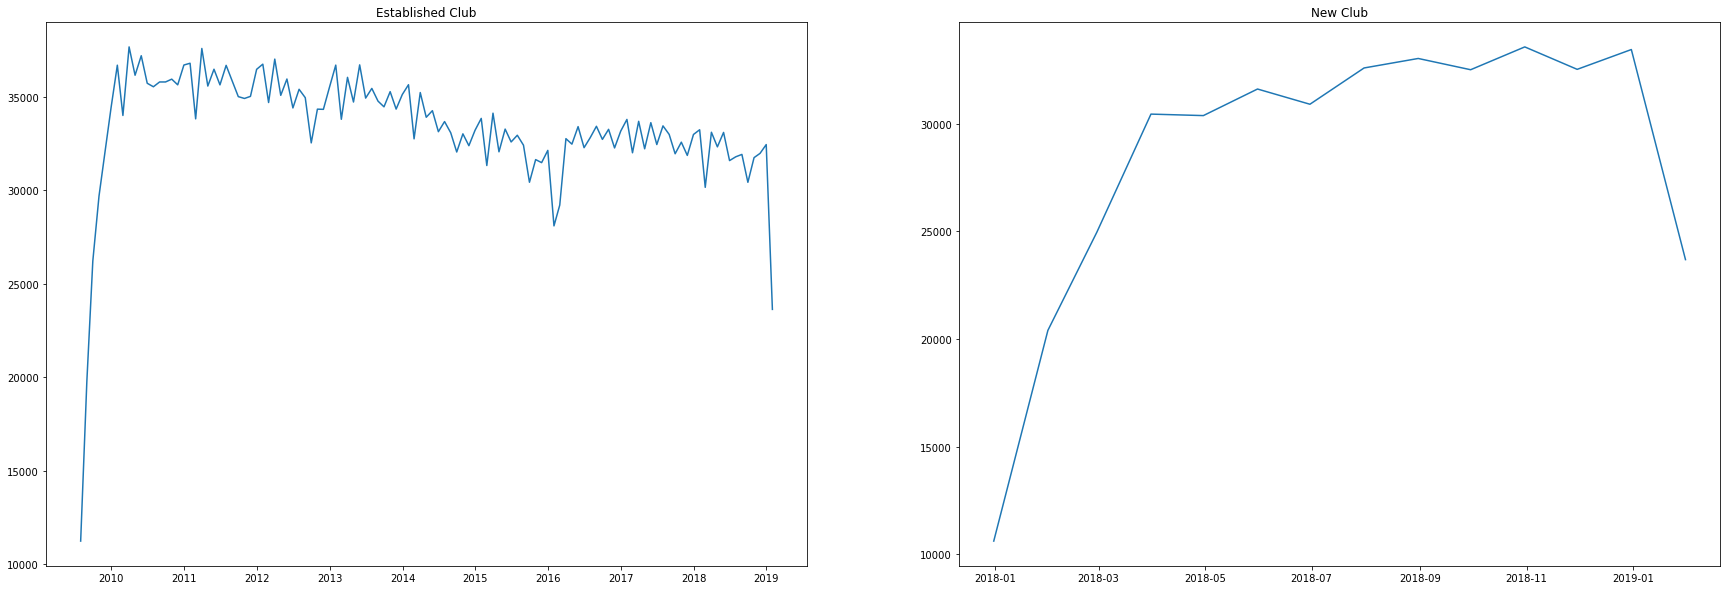

In [25]:
gb = full.groupby(
    ["Club", pd.Grouper(key="visit_datetime", freq="1M")]
).agg({
    "CustomerID": "count"
}).reset_index(
    "visit_datetime"
).rename(columns={"CustomerID": "visitors"})

fig, axs = plt.subplots(
    ncols=2, sharex=False, figsize=(30,10)
)
for i, (c, l) in enumerate(zip(["Greenwich", "Hillingdon"], ["Established Club", "New Club"])):
    ax = axs[i]
    d = gb.loc[c].reset_index(drop=True).set_index("visit_datetime")
    ax.plot(d.index, d.visitors, label=l)
    ax.set_title(l)

## Average daily visits by club by months in 2018

2018 seems to be an interesting year where the number of visits started to decrease. We thus decided to focus on that year and try to understand how the number of monhtly visits evolved in 2018 for each club. We see some interesting and very different patterns between the clubs. We see the newly opened clubs like Hiliingdon or Redbridge having a positive year where the number of visit is on the rise. However, for the more established clubs, we see the number of monthly going down. We do see some seasonal patterns, we do see less affluence during the summer which is aligned with the holidays season, we also see a high number of visits in January which is the effect of the new year's resolutions.

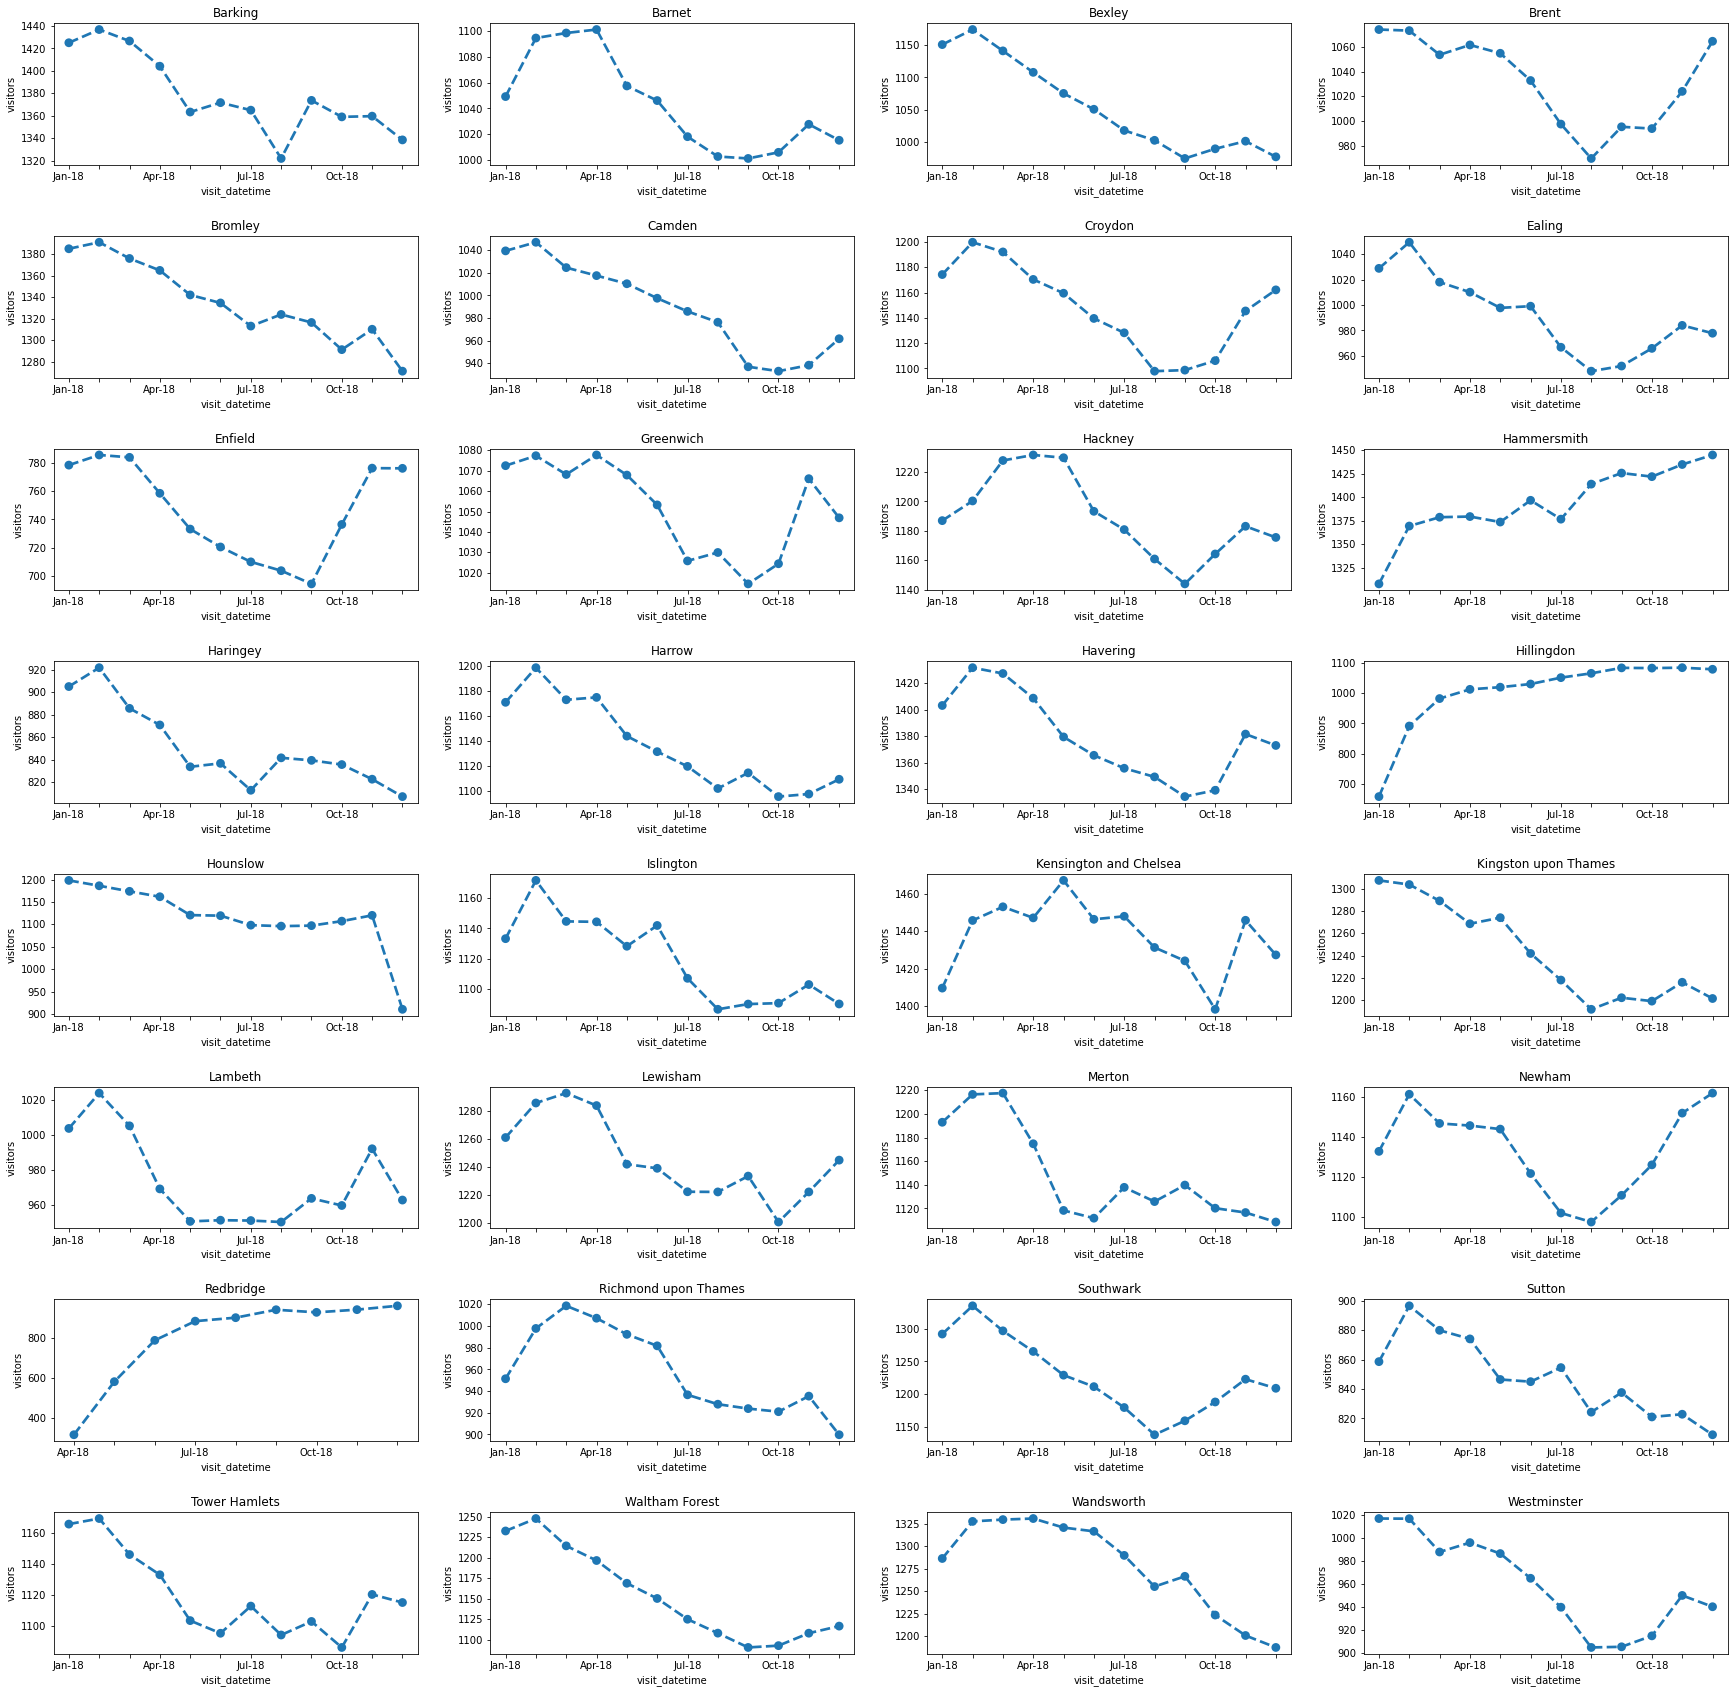

In [36]:
daily_full_2018 = full[
    full["visit_datetime"].dt.year==2018
].groupby(
    ["Club", pd.Grouper(key="visit_datetime", freq="1D")]
).agg({
    "CustomerID": "count"
}).reset_index().rename(
    columns={"CustomerID": "visitors"}
)

daily_full_2018 = daily_full_2018.groupby([
    "Club", 
    pd.Grouper(key="visit_datetime", freq="1M")
]).agg({
    "visitors": "mean"
}).reset_index("visit_datetime")

daily_full_2018["visit_datetime"] = daily_full_2018["visit_datetime"].apply(lambda d: d.strftime("%b-%y"))

fig, axs = plt.subplots(
    nrows=math.ceil(daily_full_2018.index.nunique()/4), 
    ncols=4, sharex=False, figsize=(30,30), 
    gridspec_kw={'hspace': 0.5}
)
for i, c in enumerate(daily_full_2018.index.unique()):
    ax = axs[i // 4, i % 4]
    d = daily_full_2018.loc[c].reset_index(drop=True)
    ax = sns.pointplot("visit_datetime", "visitors", data=d, ax=ax, linestyles="--")
    ax.set_title(c)
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 3 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

## Daily visits by Club

We now decide to look at a more granular level and look at the number of daily visits in 2016, 2017, 2018. We observe interesting patterns. First of all we can easily spot the newly opened clubs and see how people join the gym. The number of daily visits increases monthly by a big jump at the beginning of every month until it reaches a plateau. During each month we observe similar pattern across all the gyms, for the last week of each month we see a big drop in the number of visits. This is most likely due the people cancelling their subscribptions. The regain for the next month is the people starting their subscription. We see from this graph that there is roughly the same amount of people leaving the gym than the people joining at least in terms of number of visits.
We observe on this graph the effect of the 2016 price increase. There have been a large amount of subscriptions cancelled which has of course affected the number of daily visits. The gym were less busy. However, we see that the number of visits quickly came back to its previous state in a couple of months.

**Actionable insights:**
- Knowing that we have this less busy period is interesting. We can advise to perform the maintenance during this period as there is generally less customers impacted.
- The subscriptions seems to start on the first day of the month, to reduce the effect of the number of people joining and the number of people leaving we could advise to be more flexible in the date people can join the gym.

Text(0.5, 1.0, 'Daily Visits')

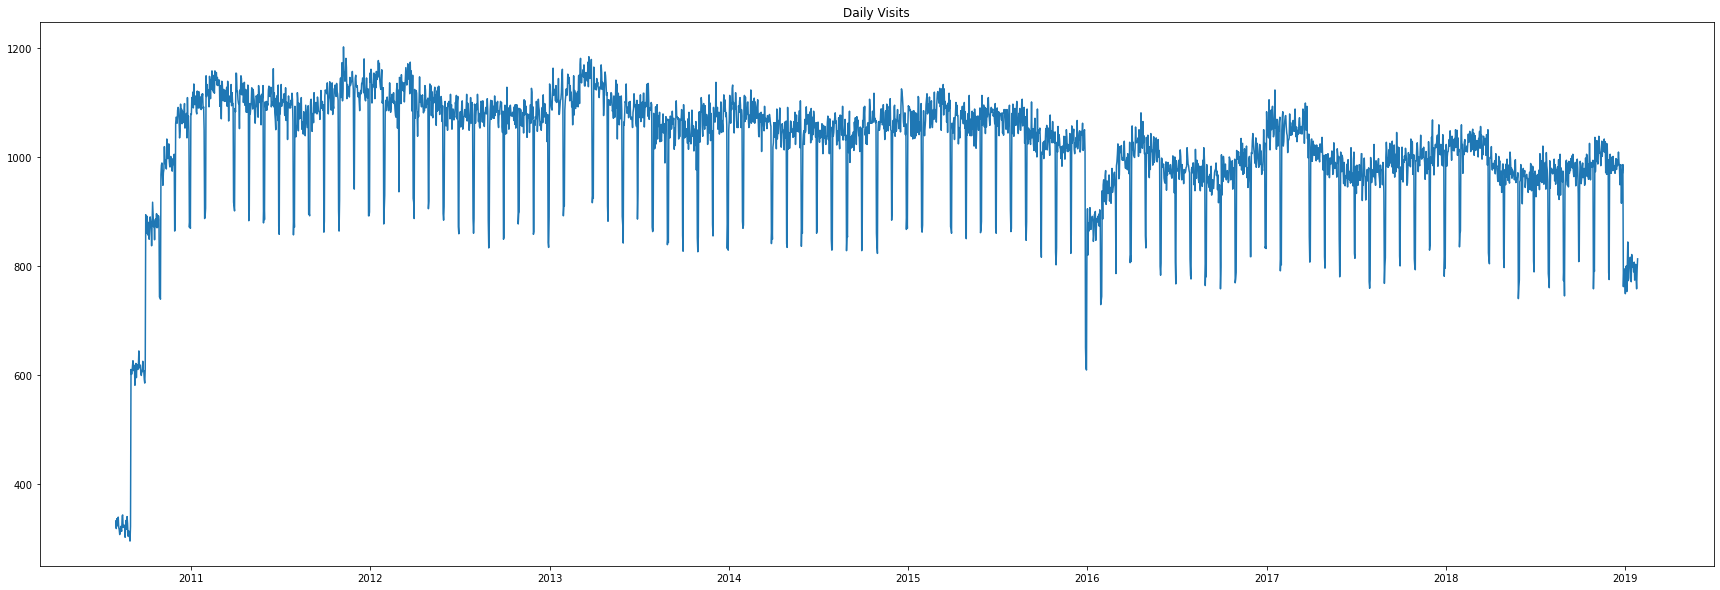

In [24]:
gb = full.groupby(
    ["Club", pd.Grouper(key="visit_datetime", freq="1D")]
).agg({
    "CustomerID": "count"
}).reset_index(
    "visit_datetime"
).rename(columns={"CustomerID": "visitors"})

fig, ax = plt.subplots(figsize=(30,10))
d = gb.loc["Lambeth"].reset_index(drop=True).set_index("visit_datetime")
ax.plot(d.index, d.visitors)
ax.set_title("Daily Visits")

#### Zoom in

Going even at a more granular level we see that the drop corresponds to the last week of each month or when the subscriptions end. Therefore these drops corresponds to the people leaving the gym. The regain seen the following weeks correpond to the people joining the gym the following month.

Text(0.5, 1.0, 'Daily Visits - 3M view')

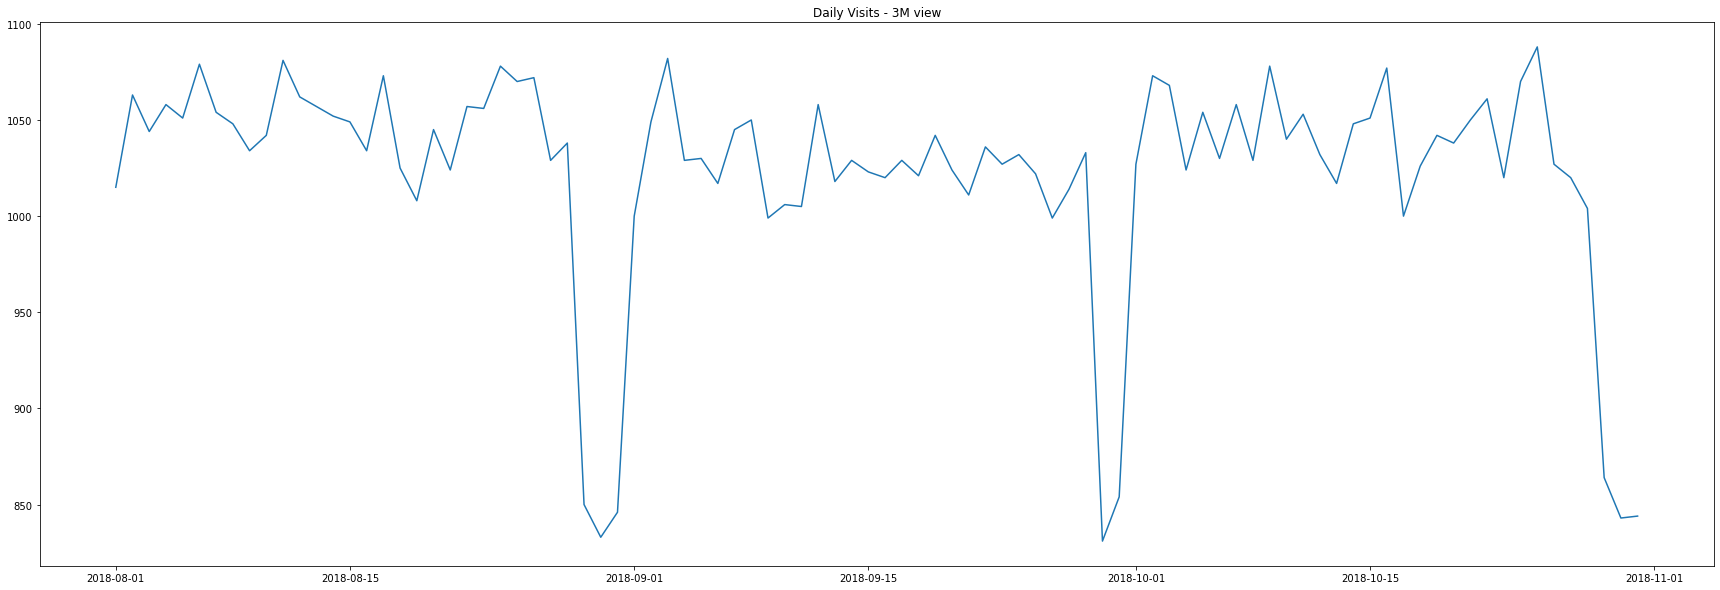

In [37]:
gb_2018_Sep = full[
    (full["visit_datetime"].dt.year==2018) &
    (full["visit_datetime"].dt.month.isin([8, 9, 10]))
].groupby(
    ["Club", pd.Grouper(key="visit_datetime", freq="1D")]
).agg({
    "CustomerID": "count"
}).reset_index(
    "visit_datetime"
).rename(columns={"CustomerID": "visitors"})

fig, axs = plt.subplots(figsize=(30,10))
d = gb_2018_Sep.loc["Greenwich"].reset_index(drop=True).set_index("visit_datetime")
axs.plot(d.index, d.visitors)
axs.set_title("Daily Visits - 3M view")

## Day of the week average number of visits by club

If we drill even deeper and look at the days of the week that are the busiest for each club. We see that the club are fairly different. Some clubs are busier during the week ends whereas others have more people during the week. The more central areas are the one which are busier during the week and less busy during the weekends. For instance Camden and Kensington clubs see a smaller affluence during the weekends. We note also that Thursday and Friday which are usually social week day are less busy. People tend to go out for drinks after work and thus don't go to the gym. However, when we looked at the different times of the day the people visit the gym, we do not see any differences between the day of the week. This is quite a surprising findings as we would expect the weekend to not have any time peaks.

**Actionable insights:**
- It would be interesting to understand where people leave and where people work. Having a multi-location pass could be of interest for the customers and would reinforce the customer engagement.

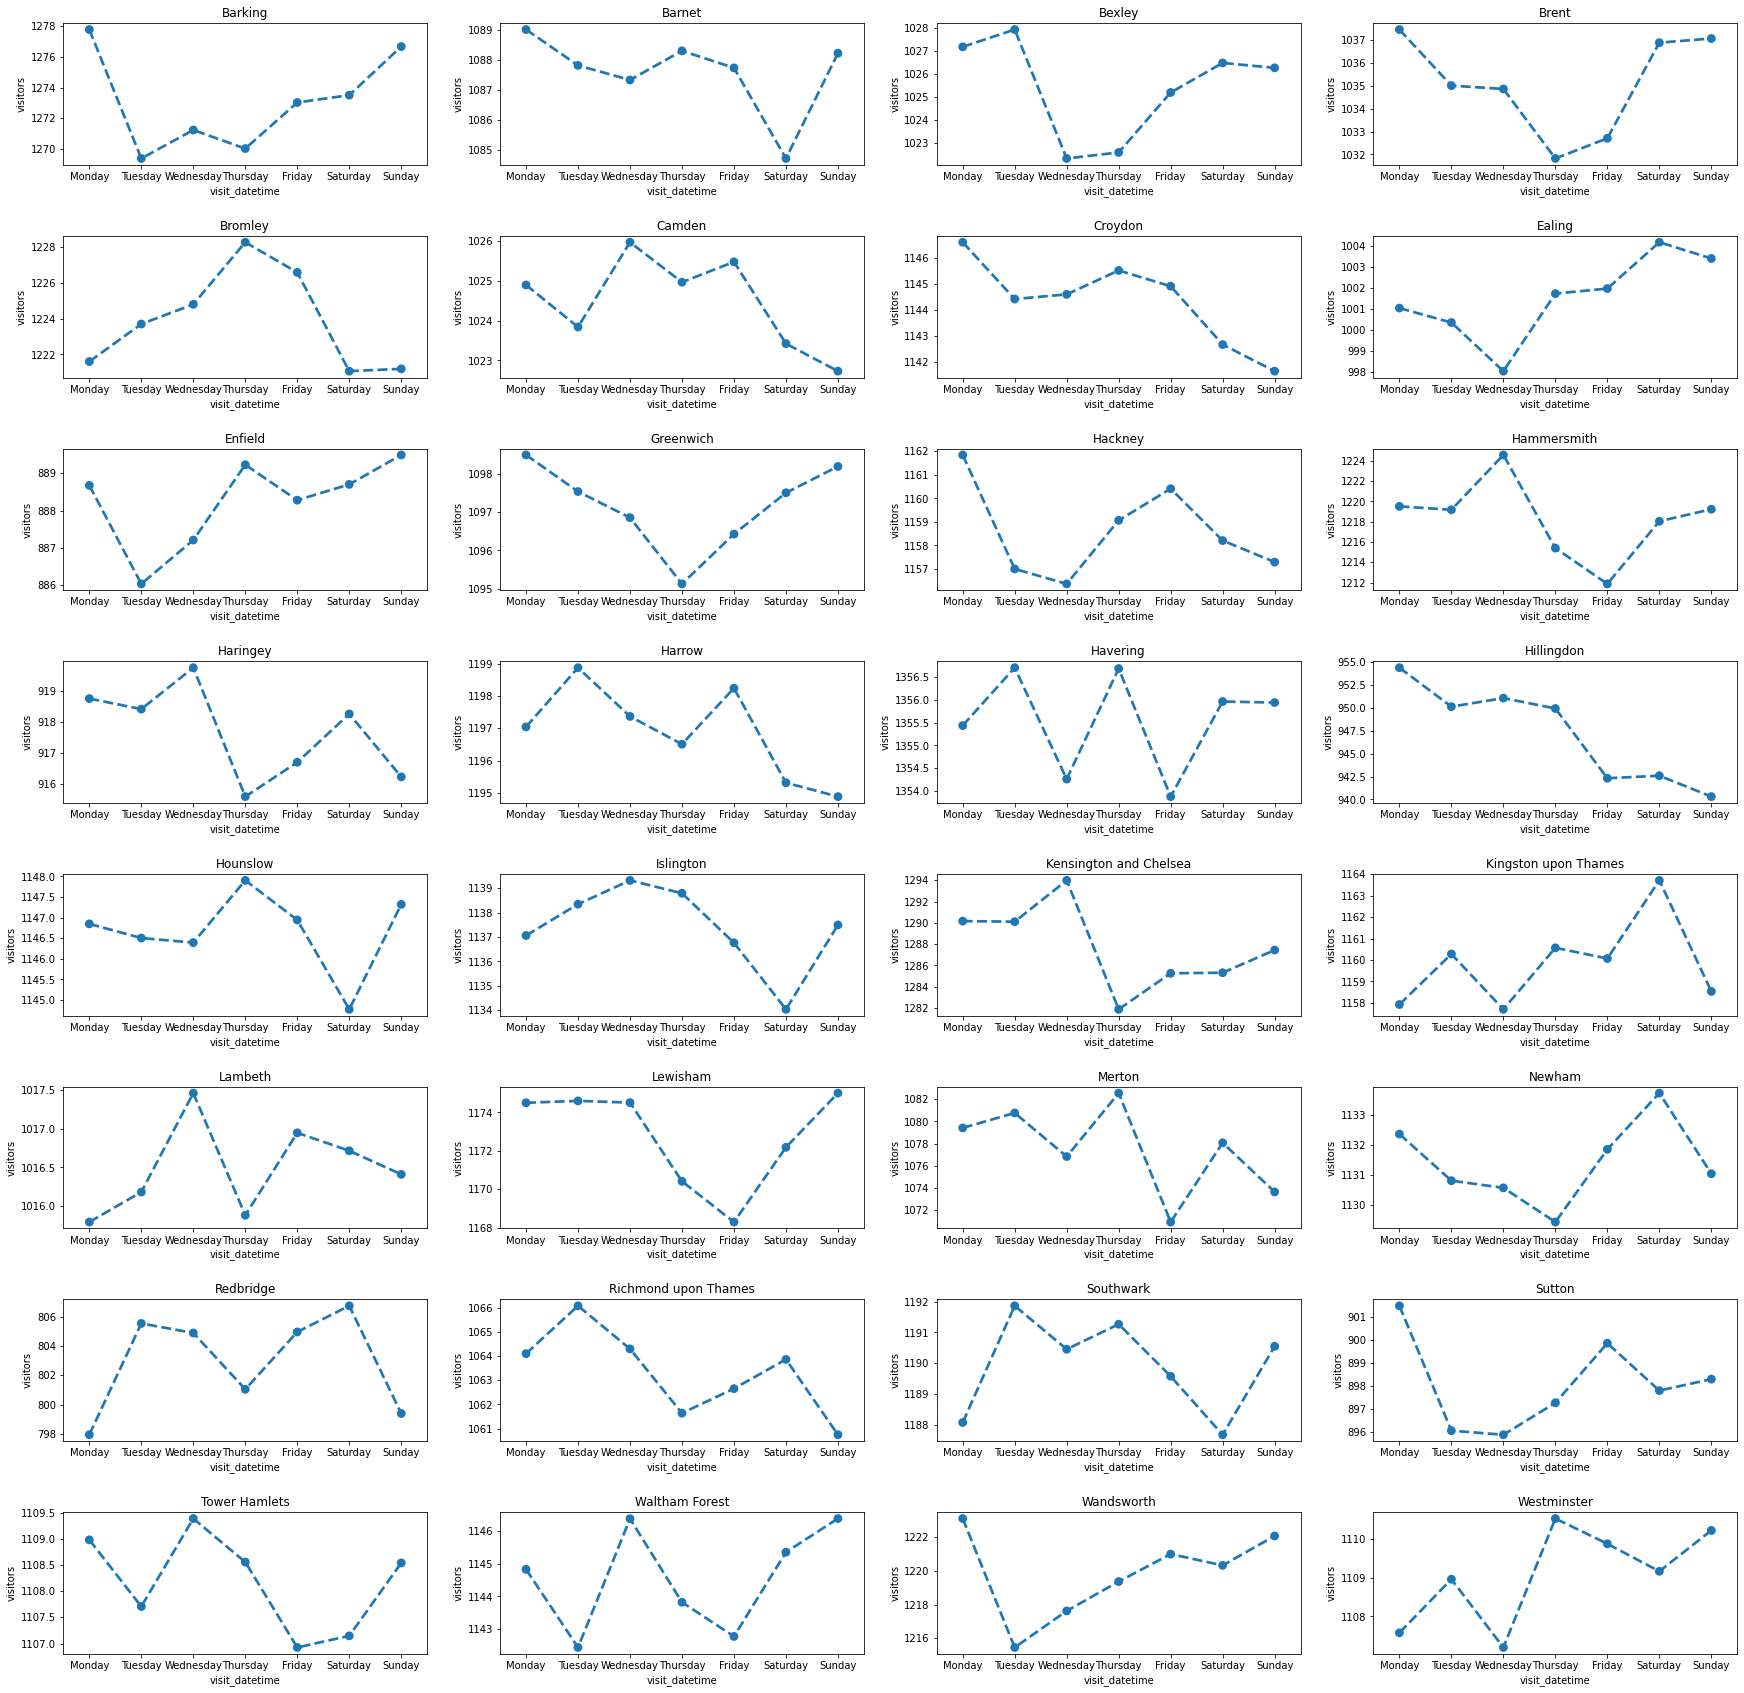

In [40]:
daily_full = full.groupby(
    ["Club", pd.Grouper(key="visit_datetime", freq="1D")]
).agg({
    "CustomerID": "count"
}).reset_index().rename(
    columns={"CustomerID": "visitors"}
)

daily_full = daily_full.groupby([
    "Club", 
    daily_full["visit_datetime"].dt.day_name(), 
    daily_full["visit_datetime"].dt.dayofweek
]).agg({
    "visitors": "mean"
}).reset_index(-2).sort_index().reset_index(-1, drop=True)

fig, axs = plt.subplots(
    nrows=math.ceil(daily_full.index.nunique()/4), 
    ncols=4, sharex=False, figsize=(30,30), 
    gridspec_kw={'hspace': 0.5}
)
for i, c in enumerate(daily_full.index.unique()):
    ax = axs[i // 4, i % 4]
    d = daily_full.loc[c].reset_index(drop=True)
    ax = sns.pointplot("visit_datetime", "visitors", data=d, ax=ax, linestyles="--")
    ax.set_title(c)

## Hours of the day average number of visits by club

Finally, looking at the time of the day people go to each gym we see the same pattern across all the gyms. Across the board we see that the clients of the gym are early birds. We see a big peak from 6am until 9am. We do see a small bump during lunch time between 11am and 1 pm, and finally we start seeing more people gradually rumping up from 4pm until it reaches its peak at 6pm and slowly go down after. Because the peak at night is more spread in time it doesn't reach the number of visits seen in the morning, there is a natural flow of people coming in and coming out. This times is very much bound to the working hours of the people. If we split the data by age group, we see that the older group, which is most likely retired and have more flexibility are the group who have a different pattern of visits. They start coming to the gym around 9-10am and the number of hourly visits remain constant throughout the day.

[Text(0, 0.5, 'visits'), Text(0.5, 0, '')]

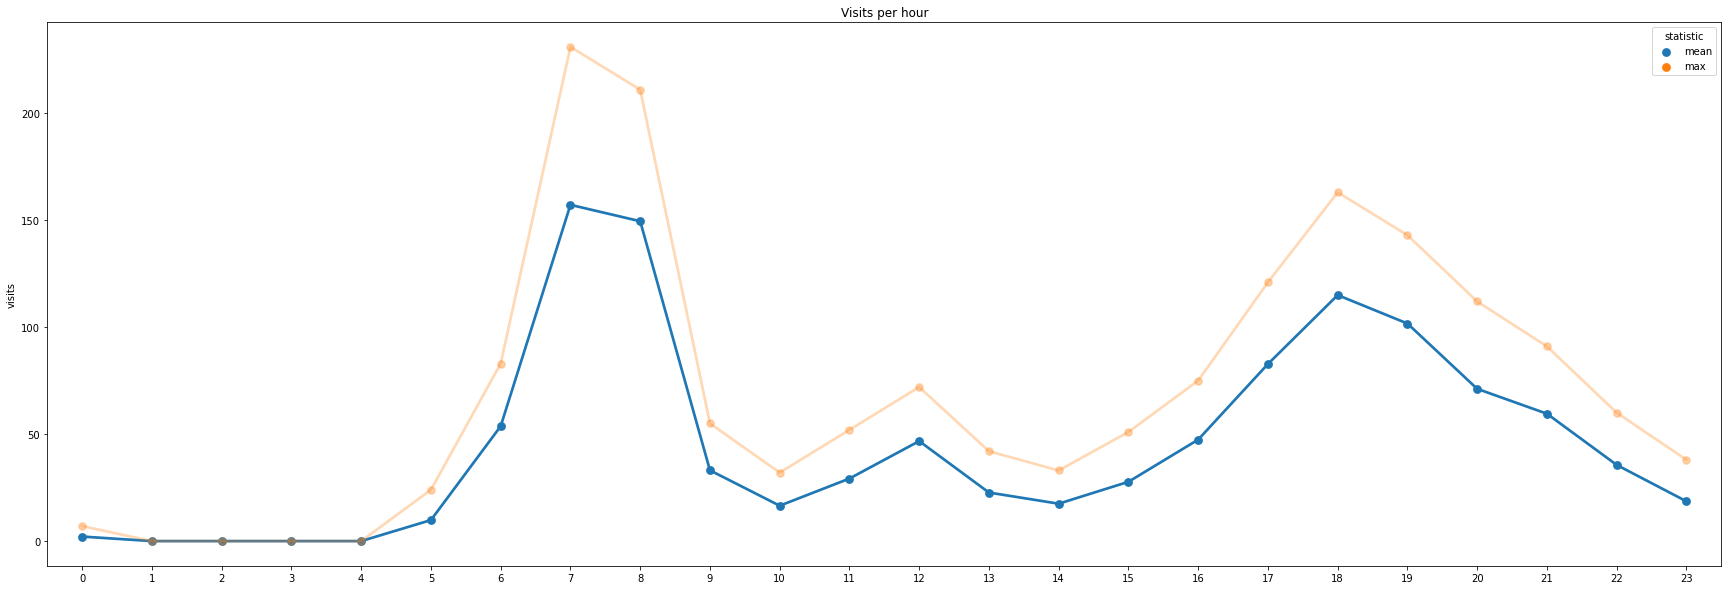

In [46]:
hourly_full = full[
    full["Club"]=="Greenwich"
].groupby(
    ["Club", pd.Grouper(key="visit_datetime", freq="1H")]
).agg({
    "CustomerID": "count"
}).reset_index().rename(
    columns={"CustomerID": "visitors"}
)

hourly_full = hourly_full.groupby([
    "Club", 
    hourly_full["visit_datetime"].dt.hour, 
]).agg({
    "visitors": ["mean", "max"]
}).xs(
    "visitors", axis=1, drop_level=True
)
hourly_full = hourly_full.reindex(
    pd.MultiIndex.from_product(
        [hourly_full.index.levels[0], np.arange(0, 24)], 
        names=['Club', 'visit_datetime']
    ), fill_value=0
).reset_index("visit_datetime")

fig, ax = plt.subplots(figsize=(30,10)
)
d = hourly_full.loc["Greenwich"].reset_index(drop=True)
d = pd.melt(d, id_vars=['visit_datetime'], var_name='statistic', value_name='value')
ax = sns.pointplot("visit_datetime", "value", hue="statistic", data=d, ax=ax)
plt.setp(ax.lines[len(ax.lines)//2:], alpha=0.3)
plt.setp(ax.collections[1], alpha=0.3)
ax.set_title("Visits per hour")
ax.set(ylabel='visits', xlabel='')

## Time of visits by day

We try to see the average number of visits by hour depending of the day of the week. The hypothese being that there should be a difference between the week and the weekend in terms of the hours of visits. People are working during the week and thus have less flexibility to go to the gym. We should see less of a peak during the weekends.

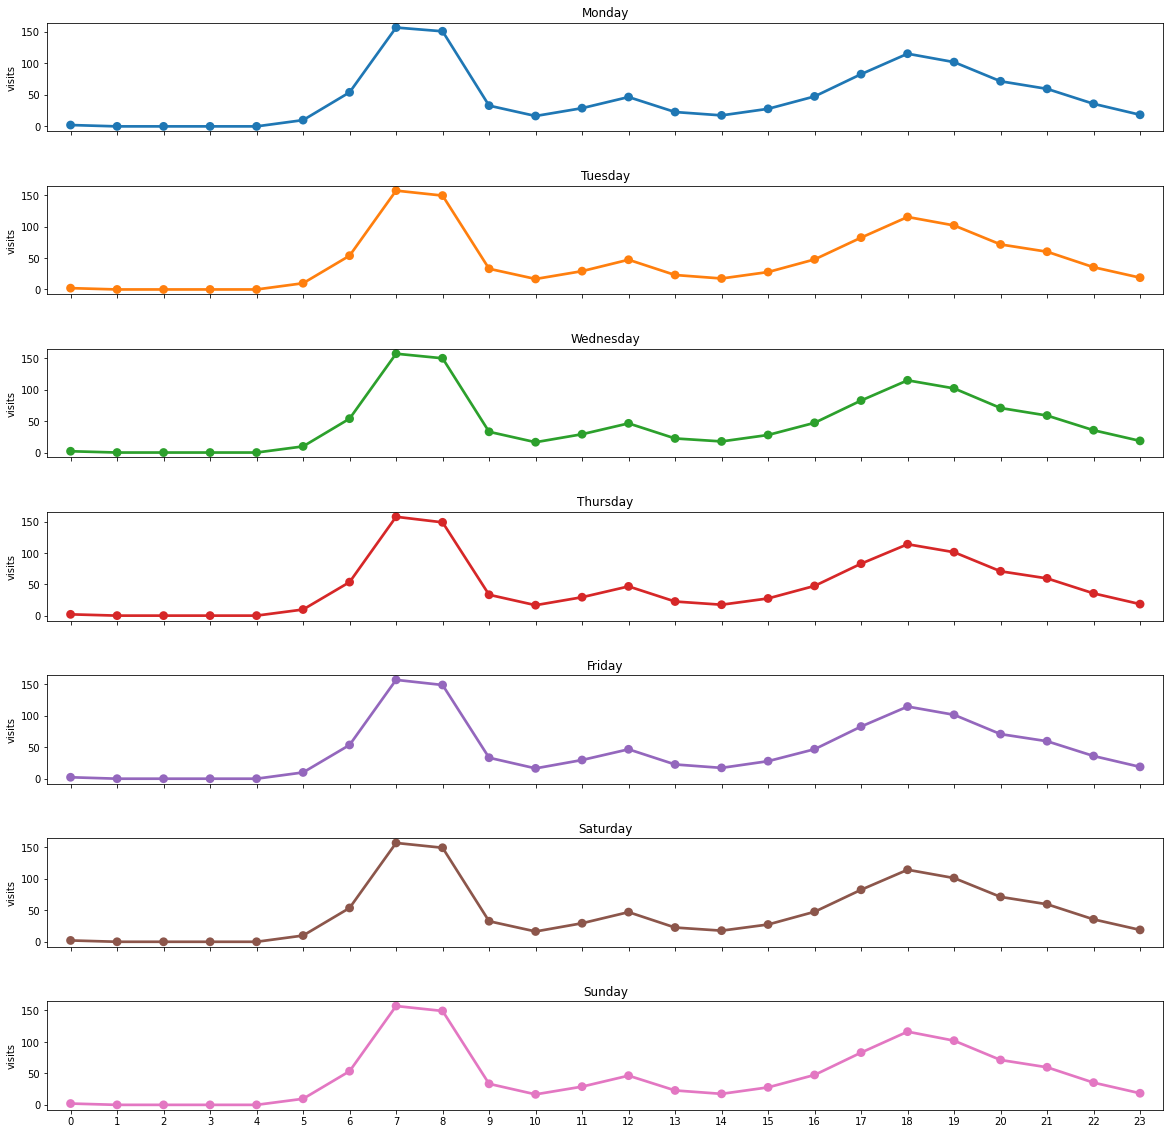

In [43]:
fig, axs = plt.subplots(nrows=7, sharex=True, figsize=(20,20), gridspec_kw={'hspace': 0.5})
legend_elements = []

for i, (day_name, color) in enumerate(zip(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
    sns.color_palette(n_colors=7)
)):
    d_hourly_full = full[
        (full["visit_datetime"].dt.day_name()==day_name)&
        (full["Club"]=="Greenwich")
    ].groupby(
        ["Club", pd.Grouper(key="visit_datetime", freq="1H")]
    ).agg({
        "CustomerID": "count"
    }).reset_index().rename(
        columns={"CustomerID": "visitors"}
    )
    
    d_hourly_full = d_hourly_full.groupby([
        "Club", 
        d_hourly_full["visit_datetime"].dt.hour, 
    ]).agg({
        "visitors": "mean"
    })
    d_hourly_full = d_hourly_full.reindex(
        pd.MultiIndex.from_product(
            [d_hourly_full.index.levels[0], np.arange(0, 24)], 
            names=['Club', 'visit_datetime']
        ), fill_value=0
    ).reset_index("visit_datetime")
    
    ax = axs[i]
    d = d_hourly_full.loc["Greenwich"].reset_index(drop=True)
    ax = sns.pointplot("visit_datetime", "visitors", data=d, ax=ax, color=color, label=day_name)
    ax.set_title(day_name)
    ax.set(ylabel='visits', xlabel='')

Interestingly enough, we do not see any differences between the week days and the week ends.

## Hours of the day average number of visits by age

As expected we see that the older people have a slightly different schedule. As they are most likely retired they can afford to go to the gym during less busy period. We see that there is a constant number of visits throughout the day. There is no peak hours like for the other age groups. The 45-54 group is victime of the peaks as well, however the difference between peak and non peak hours seems less important.

We could think that the youngest group has a more flexible schedule as they are most likely students. However it doesn't seem that this was the case. We see that they are very much following the same pattern than the active groups with a big peak in the morning a small peak during the lunch break and a medium peak in the evening.

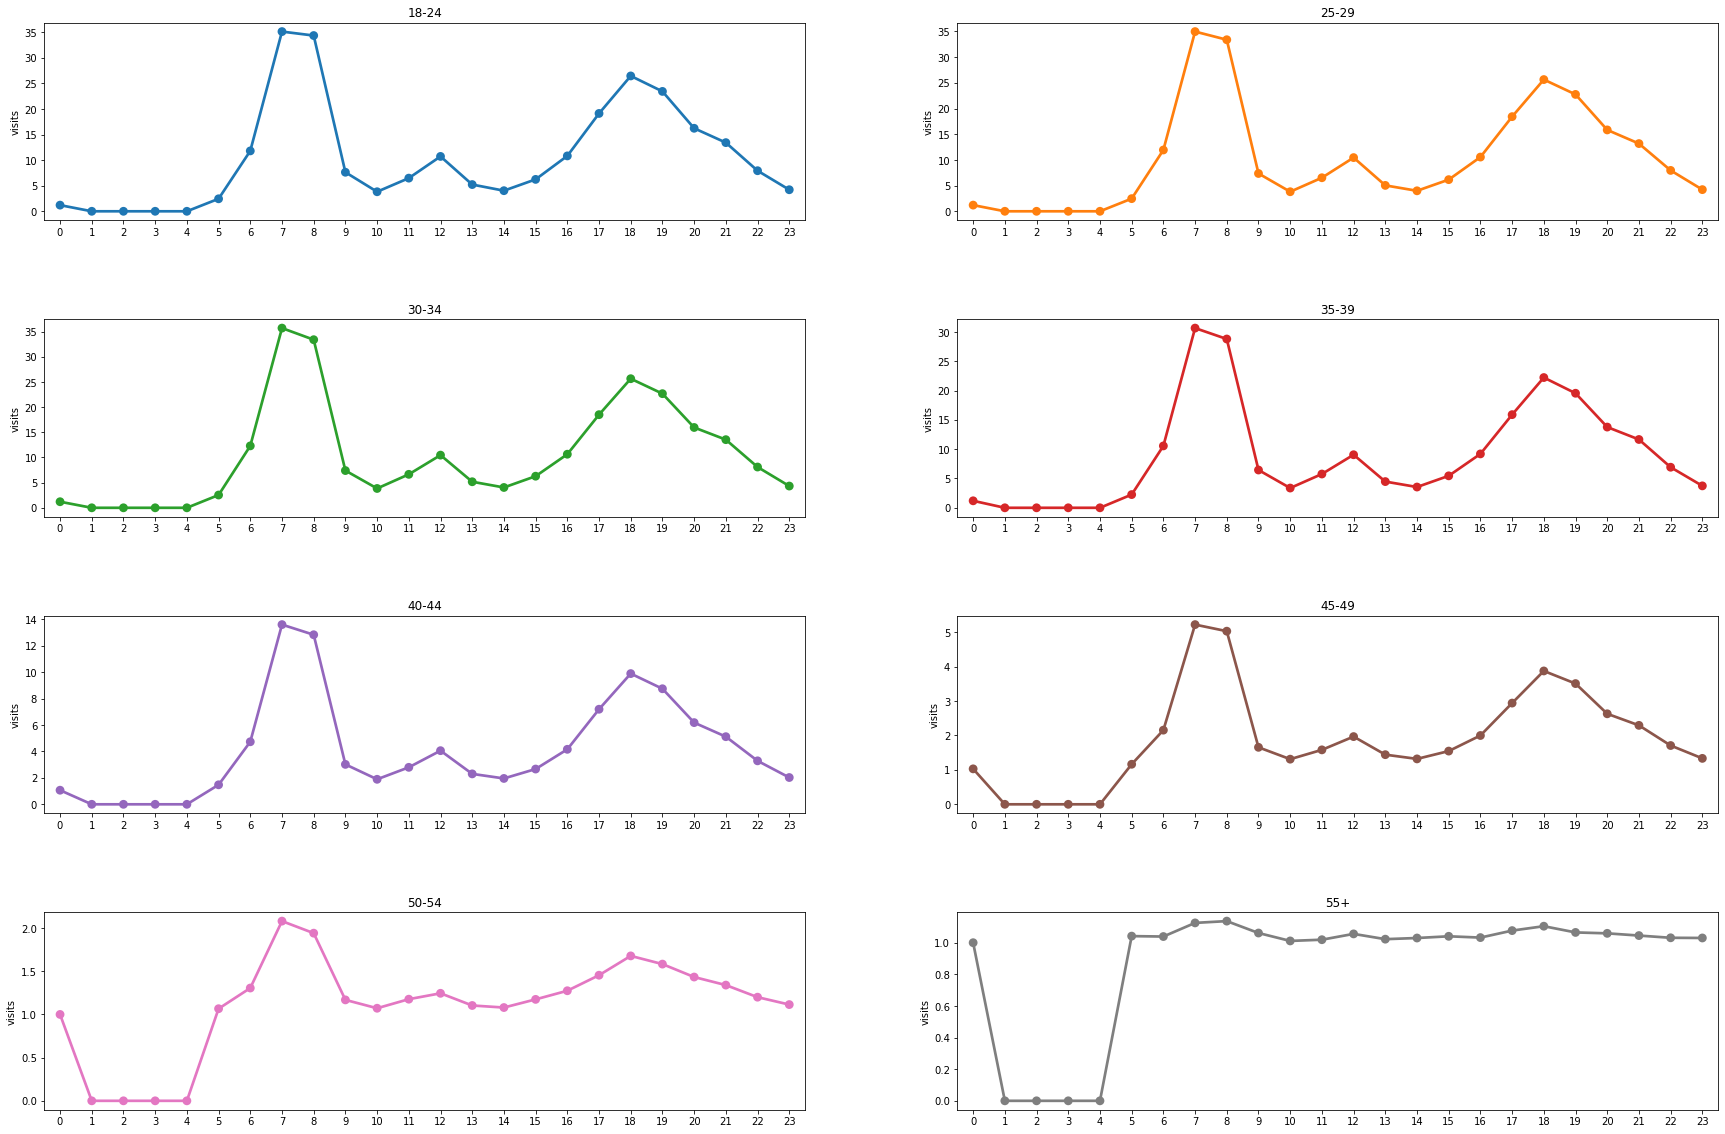

In [51]:
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False, figsize=(30,20), gridspec_kw={'hspace': 0.5})

for i, (age_band, color) in enumerate(zip(
    ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55+"], 
    sns.color_palette(n_colors=full["age_band"].nunique())
)):
    a_hourly_full = full[
        (full["age_band"]==age_band)&
        (full["Club"]=="Greenwich")
    ].groupby(
        ["Club", pd.Grouper(key="visit_datetime", freq="1H")]
    ).agg({
        "CustomerID": "count"
    }).reset_index().rename(
        columns={"CustomerID": "visitors"}
    )
    
    a_hourly_full = a_hourly_full.groupby([
        "Club", 
        a_hourly_full["visit_datetime"].dt.hour, 
    ]).agg({
        "visitors": "mean"
    })
    a_hourly_full = a_hourly_full.reindex(
        pd.MultiIndex.from_product(
            [a_hourly_full.index.levels[0], np.arange(0, 24)], 
            names=['Club', 'visit_datetime']
        ), fill_value=0
    ).reset_index("visit_datetime")
    
    ax = axs[i // 2, i % 2]
    d = a_hourly_full.loc["Greenwich"].reset_index(drop=True)
    ax = sns.pointplot("visit_datetime", "visitors", data=d, ax=ax, color=color, label=age_band)
    ax.set_title(age_band)
    ax.set(ylabel='visits', xlabel='')


## Hour of the day by subscription type

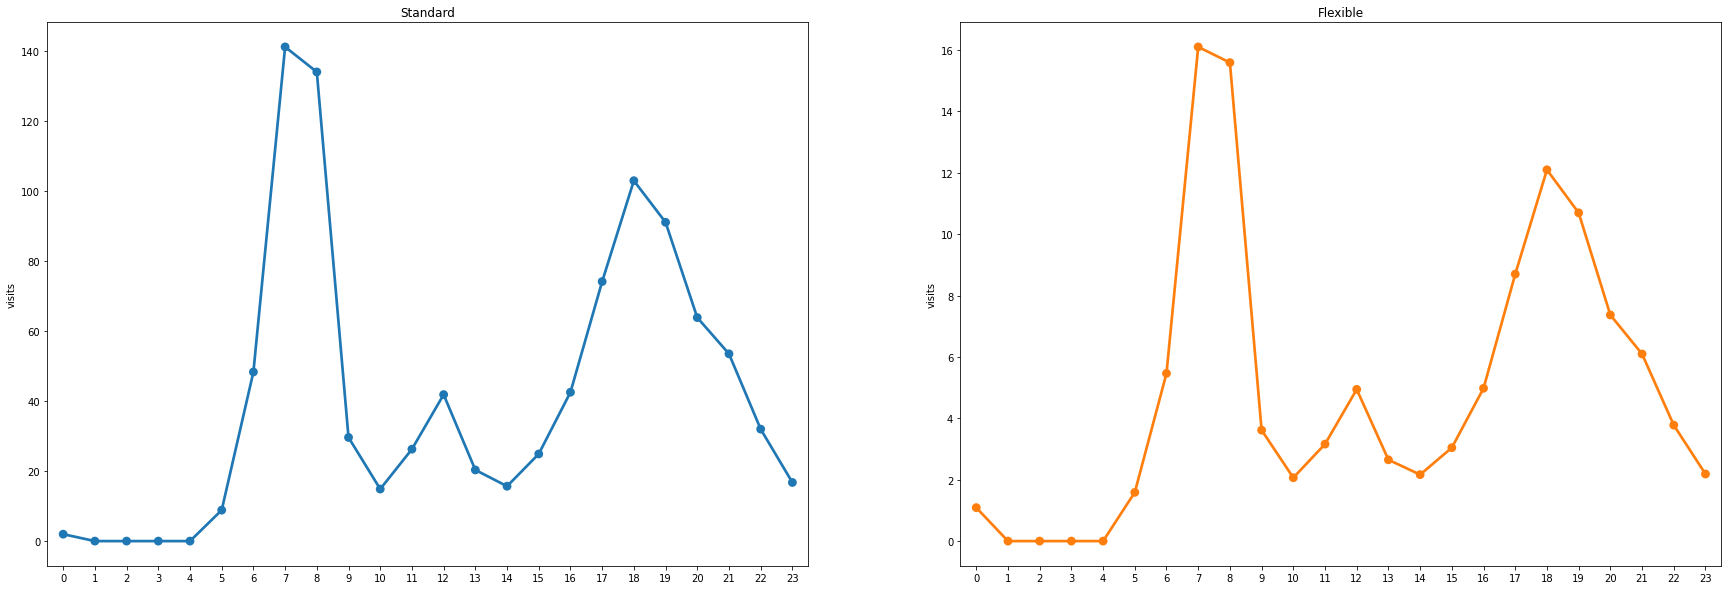

In [54]:
fig, axs = plt.subplots(ncols=2, sharex=False, figsize=(30,10), gridspec_kw={'hspace': 0.5})
legend_elements = []

for i, (s_type, color) in enumerate(zip(["Standard", "Flexible"], sns.color_palette(n_colors=2))):
    s_hourly_full = full[
        (full["Subscription Type"]==s_type)&
        (full["Club"]=="Greenwich")
    ].groupby(
        ["Club", pd.Grouper(key="visit_datetime", freq="1H")]
    ).agg({
        "CustomerID": "count"
    }).reset_index().rename(
        columns={"CustomerID": "visitors"}
    )
    
    s_hourly_full = s_hourly_full.groupby([
        "Club", 
        s_hourly_full["visit_datetime"].dt.hour, 
    ]).agg({
        "visitors": "mean"
    })
    s_hourly_full = s_hourly_full.reindex(
        pd.MultiIndex.from_product(
            [s_hourly_full.index.levels[0], np.arange(0, 24)], 
            names=['Club', 'visit_datetime']
        ), fill_value=0
    ).reset_index("visit_datetime")


    ax = axs[i]
    d = s_hourly_full.loc["Greenwich"].reset_index(drop=True)
    ax = sns.pointplot("visit_datetime", "visitors", data=d, ax=ax, color=color, label=s_type)
    ax.set_title(s_type)
    ax.set(ylabel='visits', xlabel='')

## Customer average monthly visits

In [55]:
full["subscription_age"] = full["visit_datetime"].dt.date - full["Join Date"].dt.date

In [56]:
bins = [
    pd.Timedelta(days = 31*i)
    for i in range(0, 25)
]

labels = [f"{i}M" for i in range(1, 25)]

full['subscription_age_band'] = pd.cut(full['subscription_age'], bins, labels = labels, include_lowest=True)

In [57]:
cust_monthly = full.groupby(
    ["CustomerID", "subscription_age_band"]
).agg(
    {"peakvisits": "count"}
).reset_index()

In [58]:
cust_monthly.head()

CustomerID subscription_age_band  peakvisits
0           1                    1M          20
1           1                    2M           0
2           1                    3M           0
3           1                    4M           0
4           1                    5M           0

## Percentage change in the number of monthly visits per customer

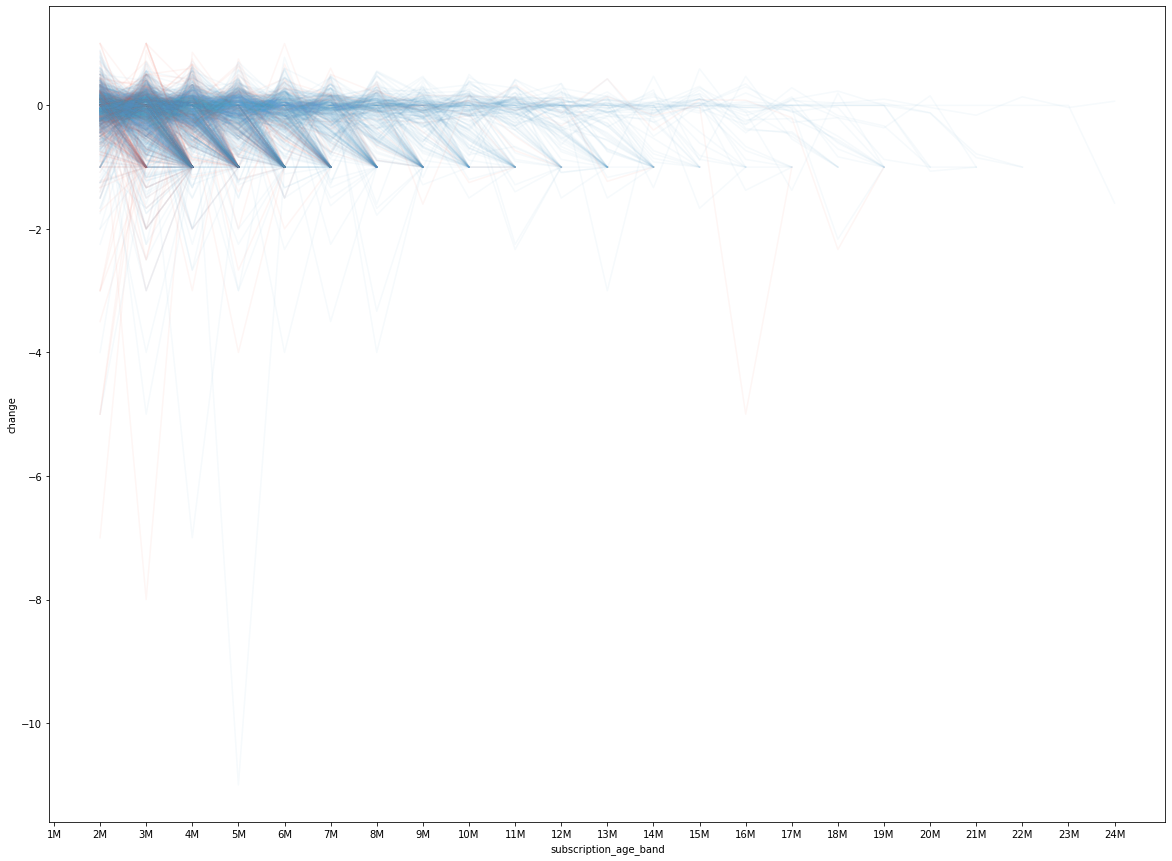

In [59]:
import random
pd.options.mode.chained_assignment = None

fig, ax = plt.subplots(figsize=(20,15))
for i, cid in enumerate(cust_monthly["CustomerID"].unique()):
    if random.random() > 0.002:
        continue
    c = cust_monthly[cust_monthly["CustomerID"]==cid]
    c.loc[:, "change"] = ((c["peakvisits"] - c["peakvisits"].shift()) / c["peakvisits"]).replace([-np.inf], -1.)
    color = "#539ecd" if subs.loc[cid, "Subscription Type"] == "Standard" else "#f44f39"
    sns.lineplot(data=c, x="subscription_age_band", y="change", ax=ax, alpha=0.05, color=color, markers=True)

## Evolution of the number of monthly visits for each customer by subscription types

We notice that the people with a flexible subscriptions are droping very early after joining the gym. They mostly drop on the second month after they joined. Not many flexible subscription owners stay for long.

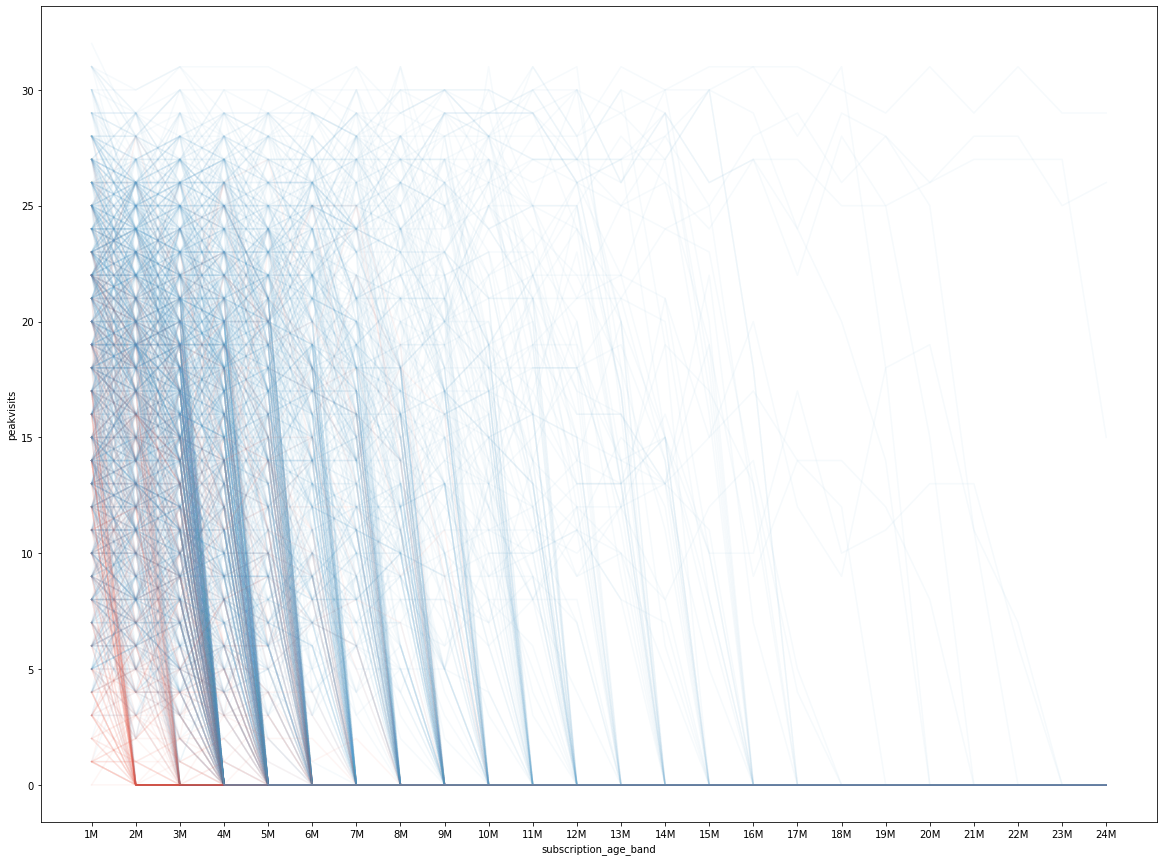

In [60]:
fig, ax = plt.subplots(figsize=(20,15))
for i, cid in enumerate(cust_monthly["CustomerID"].unique()):
    if random.random() > 0.002:
        continue
    c = cust_monthly[cust_monthly["CustomerID"]==cid]
    color = "#539ecd" if subs.loc[cid, "Subscription Type"] == "Standard" else "#f44f39"
    sns.lineplot(data=c, x="subscription_age_band", y="peakvisits", ax=ax, alpha=0.05, color=color, markers=True)

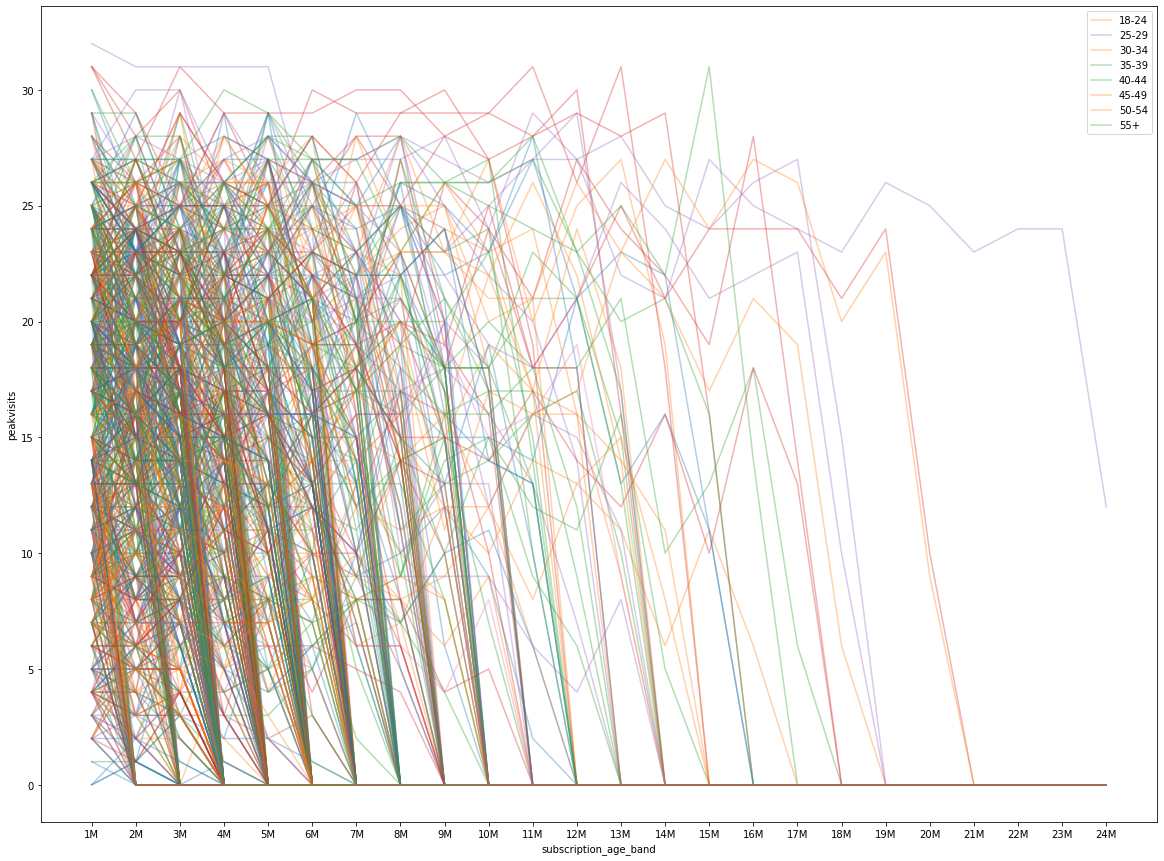

In [61]:
import random

age_bands = ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55+"]
fig, ax = plt.subplots(figsize=(20,15))
for i, cid in enumerate(cust_monthly["CustomerID"].unique()):
    if random.random() > 0.001:
        continue
    c = cust_monthly[cust_monthly["CustomerID"]==cid]
    color = sns.color_palette(n_colors=len(age_bands))[age_bands.index(subs.loc[cid, "age_band"])]
    sns.lineplot(data=c, x="subscription_age_band", y="peakvisits", ax=ax, alpha=0.35, color=color, markers=True)
    
plt.legend(labels=age_bands)

We do not observe any particular pattern when we split by age in terms of number of month before leaving

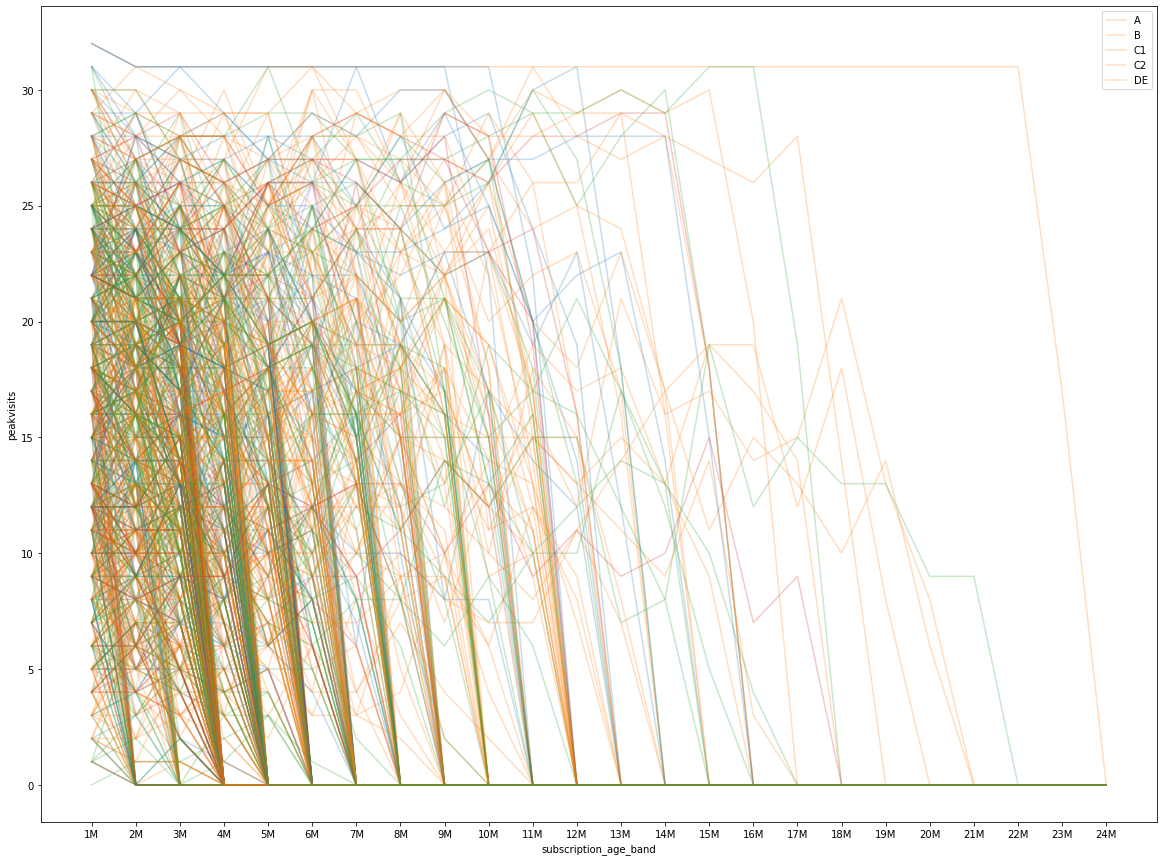

In [62]:
affluence_bands = ["A", "B", "C1", "C2", "DE"]
fig, ax = plt.subplots(figsize=(20,15))
for i, cid in enumerate(cust_monthly["CustomerID"].unique()):
    if random.random() > 0.001:
        continue
    c = cust_monthly[cust_monthly["CustomerID"]==cid]
    color = sns.color_palette(n_colors=len(affluence_bands))[affluence_bands.index(subs.loc[cid, "Affluence"])]
    sns.lineplot(data=c, x="subscription_age_band", y="peakvisits", ax=ax, alpha=0.25, color=color, markers=True)
    
plt.legend(labels=affluence_bands)

## Average monthly visits per customer

We now decide to orient our analysis to the distribution of the number of times a month a customer goes to the gym. we can identify different groups as the distribution is multimodal. We see the people going to the gym once a week, the people going twice, three times or four times a week corresponding to the bumps around 5, 10, 15, 20. Most of the people go three times a week. We look if there was differences between the gyms but the distribution of monthly visits was pretty much the same.

**Actionable insights:**
- With the introduction to the day pass, the people going 5 times or more to the gym would privilege the monthly subscription as it is more economically efficient for them. They could increase their day pass price to £6.5 and they would still have the same effect.

In [63]:
cust_monthly_mean = full.groupby(
    ["CustomerID", pd.Grouper(key="visit_datetime", freq="1M")]
).agg(
    {"peakvisits": ["count", "sum"]}
).xs(
    "peakvisits", axis=1, drop_level=True
).rename(
    columns={"sum": "peakvisits"}
).reset_index().groupby("CustomerID").agg({"count": "mean"})

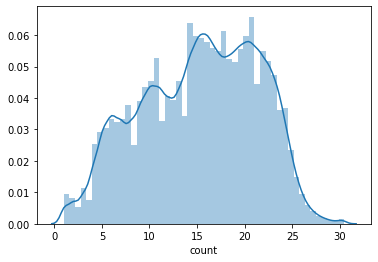

In [64]:
sns.distplot(cust_monthly_mean["count"])

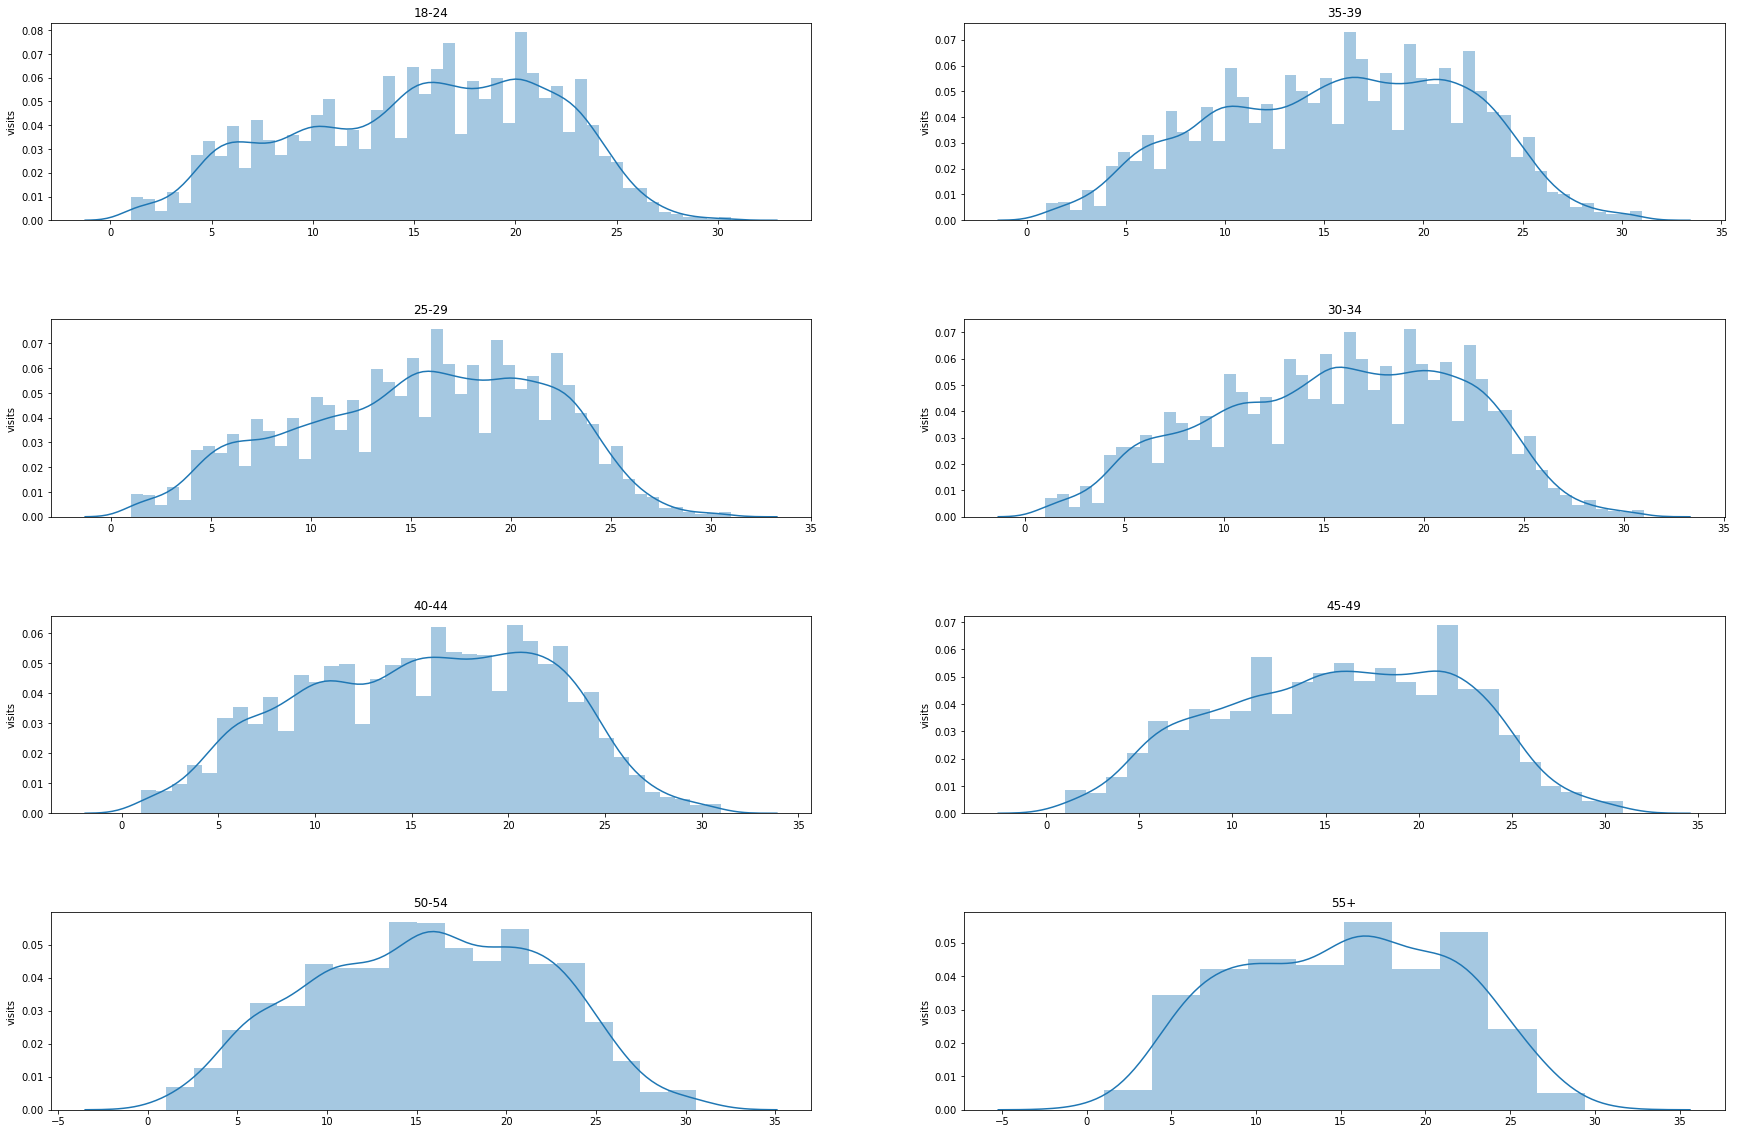

In [23]:
fig, axs = plt.subplots(
    nrows=4, ncols=2, sharex=False, figsize=(30,20), 
    gridspec_kw={'hspace': 0.5}
)

for i, age_band in enumerate(["18-24", "35-39", "25-29", "30-34", "40-44", "45-49", "50-54", "55+"]): 
    cust_age_monthly_mean = full[
        (full["visit_datetime"].dt.year==2018)&
        (full["age_band"]==age_band)
    ].groupby(
        ["CustomerID", pd.Grouper(key="visit_datetime", freq="1M")]
    ).agg(
        {"peakvisits": "count"}
    ).reset_index().groupby(
        ["CustomerID"]
    ).agg(
        {"peakvisits": "mean"}
    ).reset_index("CustomerID")

    ax = axs[i // 2, i % 2]
    sns.distplot(cust_age_monthly_mean["peakvisits"], ax=ax)
    ax.set_title(age_band)
    ax.set(ylabel='visits', xlabel='')

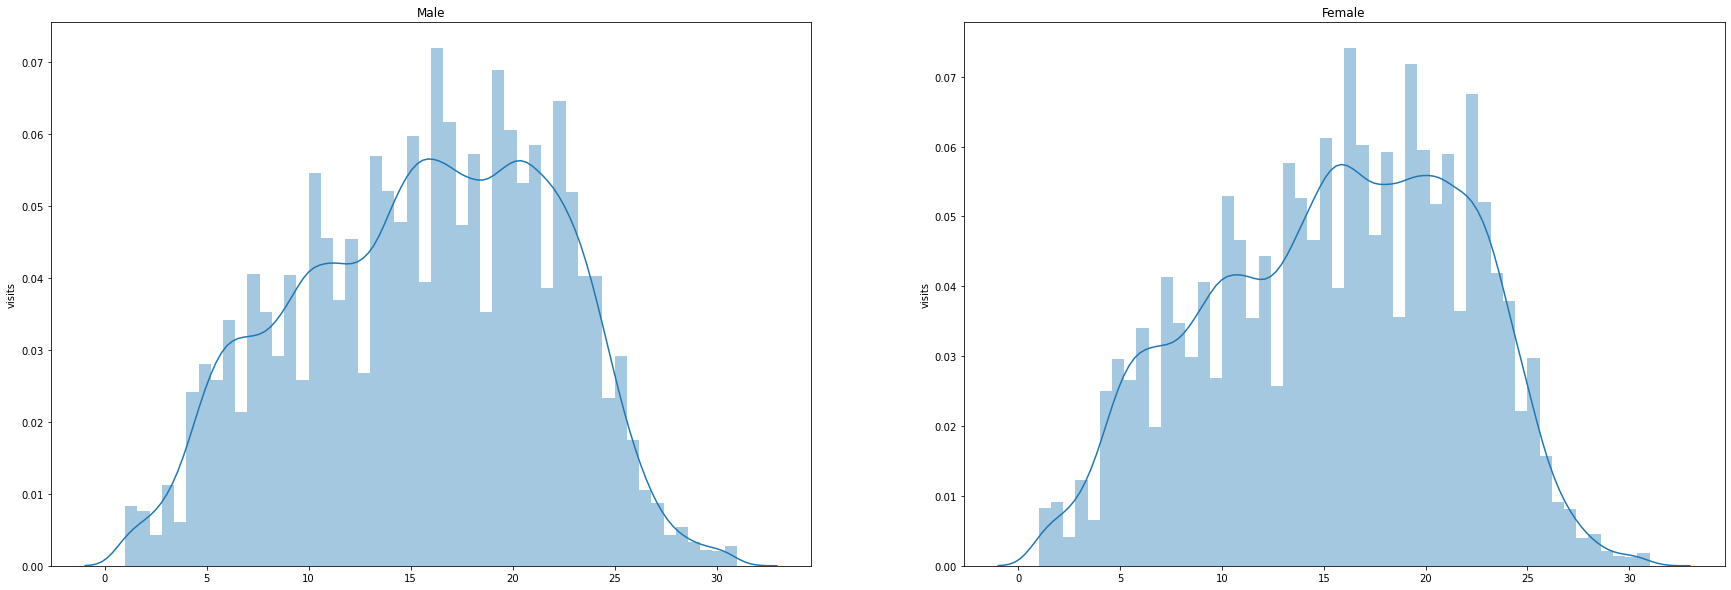

In [27]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, sharex=False, figsize=(30,10), 
    gridspec_kw={'hspace': 0.5}
)

for i, gender in enumerate(["Male", "Female"]): 
    cust_gender_monthly_mean = full[
        (full["visit_datetime"].dt.year==2018)&
        (full["Gender"]==gender)
    ].groupby(
        ["CustomerID", pd.Grouper(key="visit_datetime", freq="1M")]
    ).agg(
        {"peakvisits": "count"}
    ).reset_index().groupby(
        ["CustomerID"]
    ).agg(
        {"peakvisits": "mean"}
    ).reset_index("CustomerID")

    ax = axs[i]
    sns.distplot(cust_gender_monthly_mean["peakvisits"], ax=ax)
    ax.set_title(gender)
    ax.set(ylabel='visits', xlabel='')

In [43]:
cust_peak_monthly_mean = full.groupby(
    ["CustomerID", pd.Grouper(key="visit_datetime", freq="1M")]
).agg(
    {"peakvisits": ["count", "sum"]}
).xs(
    "peakvisits", axis=1, drop_level=True
).reset_index()

cust_peak_monthly_mean["peak_ratio"] = cust_peak_monthly_mean["sum"] / cust_peak_monthly_mean["count"]

cust_peak_monthly_mean = cust_peak_monthly_mean.groupby(
    ["CustomerID"]
).agg(
    {"peak_ratio": "mean", "count": "mean"}
).reset_index(
    "CustomerID"
).join(subs, on="CustomerID", how="left")

In [45]:
cust_peak_monthly_mean.head()

CustomerID  peak_ratio      count       Club  Join Date Affluence  Gender  \
0           1    0.450000  20.000000    Enfield 2011-12-01        C1    Male   
1           2    0.552083   9.250000  Greenwich 2018-06-01         A  Female   
2           3    0.658713  20.625000  Islington 2018-03-01         B  Female   
3           4    0.605556  17.333333   Hounslow 2015-10-01        C1  Female   
4           5    0.669425  11.625000     Barnet 2015-05-01        C2    Male   

  Subscription Type   End Date  BirthYear  age age_band  tenure  
0          Standard 2011-12-01       1992   19    18-24       0  
1          Standard        NaT       1972   46    45-54       7  
2          Standard 2018-10-01       1985   33    25-34       7  
3          Standard 2015-12-01       1972   43    35-44       2  
4          Standard 2015-12-01       1982   33    25-34       7

## Correlations

If we look at the correlation between the tenure, the age, the number of times a client goes to the gym in a month and the number of time he goes to the gym during a peak time, we see a fairly high positive correlation between the tenure and the monthly number of visits. If the clients are engaged they tend to stay a member longer. This is sort of expected as people don't want to pay for a service they don't use. We also note a small negative correlation between the tenure and the number of times someone goes to the gym during peak time. We can conclude that the fact that the gym are busy has an impact on the tenure of the clients.

**Actionable insights:**
- Overall we see that it is important to make the gym not too busy to make sure people remain members of the gym. 

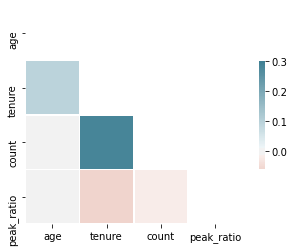

In [48]:
corr = cust_peak_monthly_mean[["age", "tenure", "count", "peak_ratio"]].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(20, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

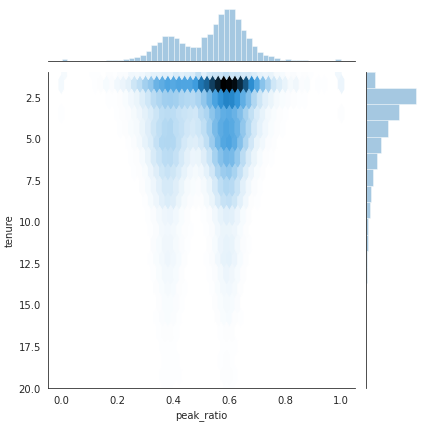

In [58]:
with sns.axes_style('white'):
    sns.jointplot("peak_ratio", "tenure", cust_peak_monthly_mean, kind='hex', ylim=20)

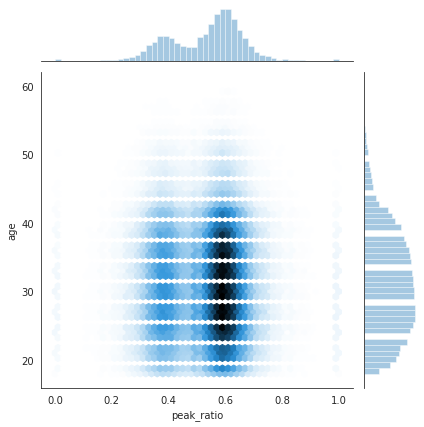

In [52]:
with sns.axes_style('white'):
    sns.jointplot("peak_ratio", "age", cust_peak_monthly_mean, kind='hex')

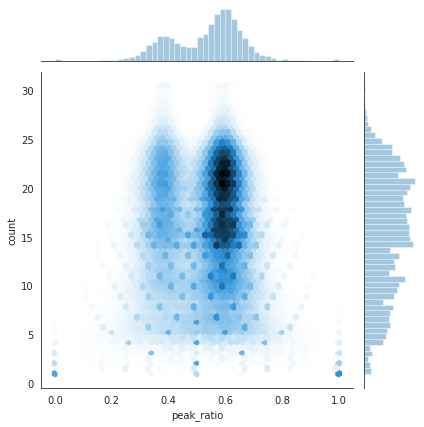

In [63]:
with sns.axes_style('white'):
    sns.jointplot("peak_ratio", "count", cust_peak_monthly_mean, kind='hex')

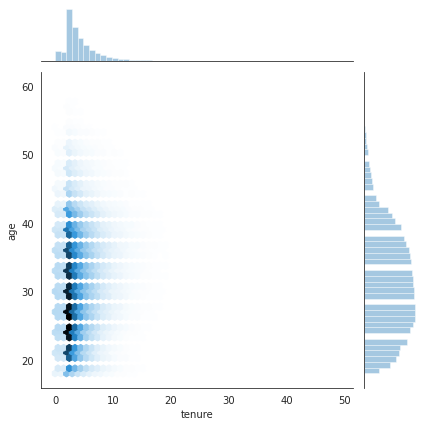

In [61]:
with sns.axes_style('white'):
    sns.jointplot("tenure", "age", cust_peak_monthly_mean, kind='hex')

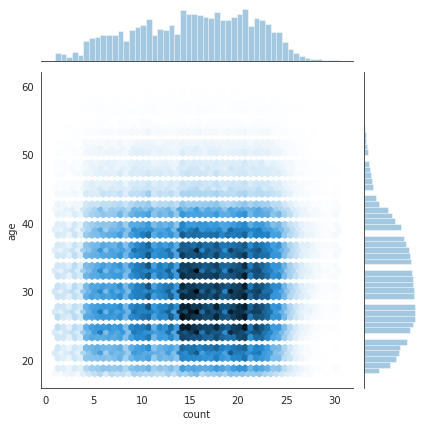

In [62]:
with sns.axes_style('white'):
    sns.jointplot("count", "age", cust_peak_monthly_mean, kind='hex')

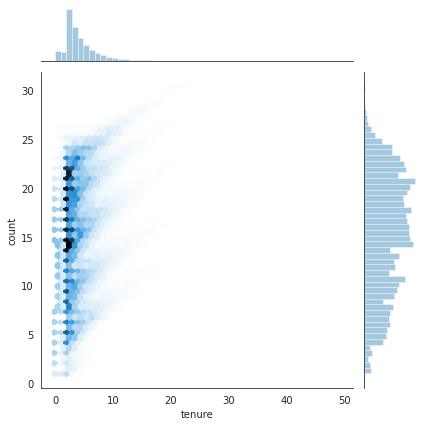

In [64]:
with sns.axes_style('white'):
    sns.jointplot("tenure", "count", cust_peak_monthly_mean, kind='hex')